Connected to tracking-barbell-exercises (Python 3.8.15)

In [1]:
import sys
sys.path.append("../../src")
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from features.TemporalAbstraction import NumericalAbstraction
from features.FrequencyAbstraction import FourierTransformation

In [2]:
# --------------------------------------------------------------
# Load data
# --------------------------------------------------------------
df = pd.read_pickle("../../data/interim/02_outliers_removed_IQR.pkl")
predictor_columns = df.columns[:6].tolist()
# Plot settings

plt.style.use("fivethirtyeight")
plt.rcParams["figure.figsize"] = (20, 5)
plt.rcParams["figure.dpi"] = 100
plt.rcParams["lines.linewidth"] = 2

In [3]:
# --------------------------------------------------------------
# Dealing with missing values (imputation)
# --------------------------------------------------------------
for col in predictor_columns:
    df[col] = df[col].interpolate()

df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 9009 entries, 2019-01-11 15:08:05.200000 to 2019-01-20 17:33:27.800000
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   acc_x        9009 non-null   float64
 1   acc_y        9009 non-null   float64
 2   acc_z        9009 non-null   float64
 3   gyr_x        9009 non-null   float64
 4   gyr_y        9009 non-null   float64
 5   gyr_z        9009 non-null   float64
 6   participant  9009 non-null   object 
 7   label        9009 non-null   object 
 8   category     9009 non-null   object 
 9   set          9009 non-null   int32  
dtypes: float64(6), int32(1), object(3)
memory usage: 739.0+ KB


array([<AxesSubplot: xlabel='epoch (ms)'>,
       <AxesSubplot: xlabel='epoch (ms)'>], dtype=object)

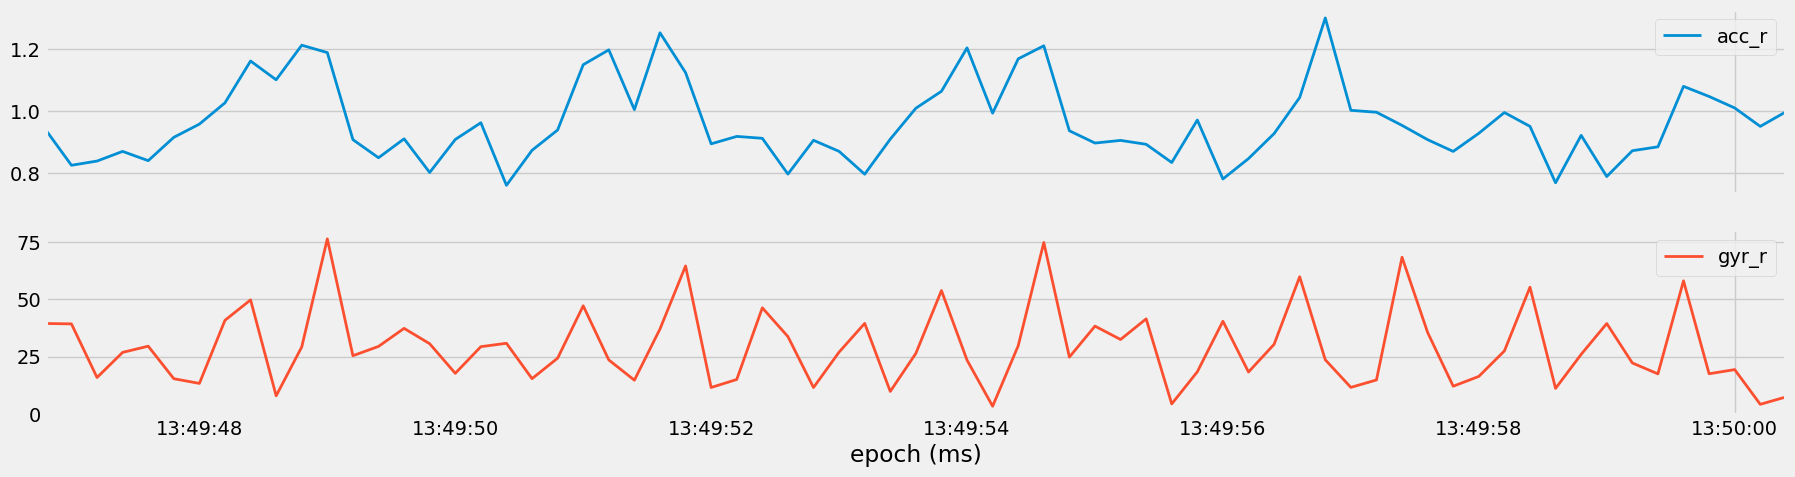

In [4]:
# --------------------------------------------------------------
# Sum of squares attributes
# --------------------------------------------------------------
df_squared = df.copy()
acc_r = (
    df_squared["acc_x"].pow(2) + df_squared["acc_y"].pow(2) + df_squared["acc_z"].pow(2)
)

gyr_r = (
    df_squared["gyr_x"].pow(2) + df_squared["gyr_y"].pow(2) + df_squared["gyr_z"].pow(2)
)

df_squared["acc_r"] = np.sqrt(acc_r)
df_squared["gyr_r"] = np.sqrt(gyr_r)
subset = df_squared[df_squared["set"] == 12]
subset[["acc_r", "gyr_r"]].plot(subplots=True)

In [5]:
# --------------------------------------------------------------
# Temporal abstraction
# --------------------------------------------------------------
df_temporal = df_squared.copy()
NumAbs = NumericalAbstraction()
predictor_columns = predictor_columns + ["acc_r", "gyr_r"]
ws = int(1000 / 200)  # window size
# Splitting the data frame into subsets to avoid moving the rolling window
# over data belonging to different subsets, e.g. 'bench' and 'row'.

df_temporal_list = []
for s in df_temporal["set"].unique():
    subset = df_temporal.query("set == @s").copy()
    subset = NumAbs.abstract_numerical(
        subset, predictor_columns, window_size=ws, aggregation_function="mean"
    )
    subset = NumAbs.abstract_numerical(
        subset, predictor_columns, window_size=ws, aggregation_function="std"
    )
    df_temporal_list.append(subset)

df_temporal = pd.concat(df_temporal_list)

c:\Users\anast\Desktop\Barbell\data-science-template\notebooks\features_experiments\../../src\features\FrequencyAbstraction.py:67: RuntimeWarning: divide by zero encountered in log
  data_table.loc[i, col + "_pse"] = -np.sum(np.log(PSD_pdf) * PSD_pdf)
c:\Users\anast\Desktop\Barbell\data-science-template\notebooks\features_experiments\../../src\features\FrequencyAbstraction.py:67: RuntimeWarning: invalid value encountered in multiply
  data_table.loc[i, col + "_pse"] = -np.sum(np.log(PSD_pdf) * PSD_pdf)


<AxesSubplot: >

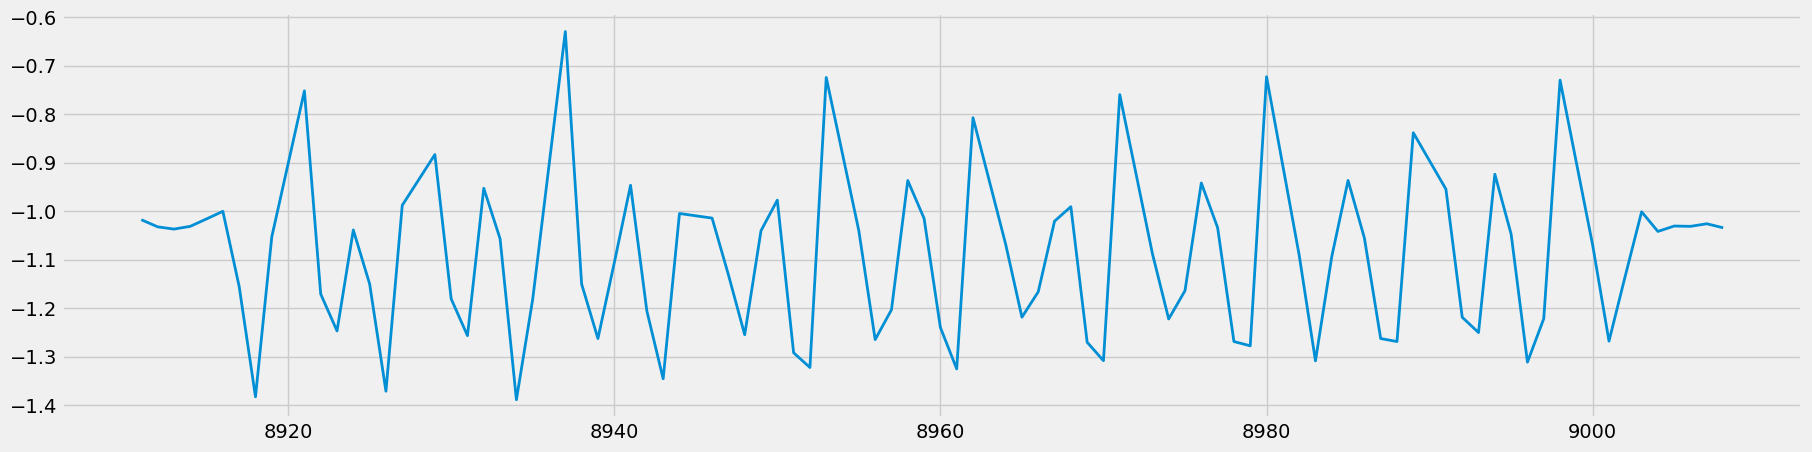

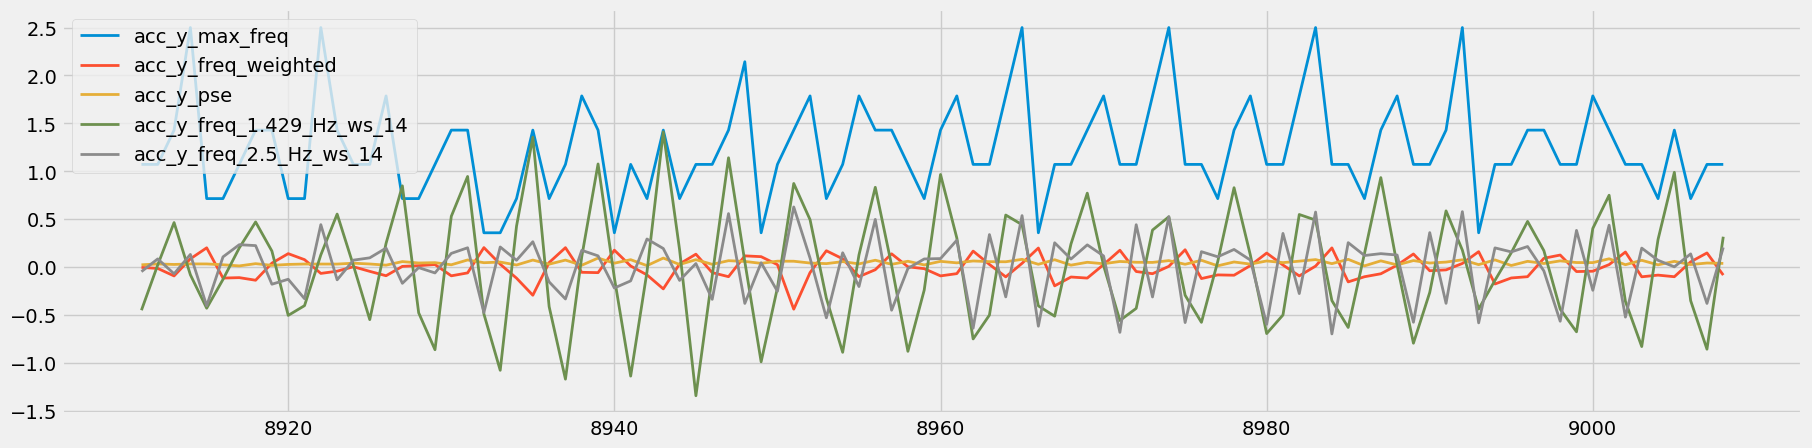

In [6]:
# --------------------------------------------------------------
# Frequency features
# --------------------------------------------------------------
df_freq = df_temporal.copy().reset_index()
FreqAbs = FourierTransformation()
sr = int(1000 / 200)  # sampling rate (the number of samples per second)
ws = 14
df_freq = FreqAbs.abstract_frequency(df_freq, ["acc_y"], ws, sr)
# Visualize result

subset = df_freq.query("set == 90")
subset["acc_y"].plot()
subset[
    [
        "acc_y_max_freq",
        "acc_y_freq_weighted",
        "acc_y_pse",
        "acc_y_freq_1.429_Hz_ws_14",
        "acc_y_freq_2.5_Hz_ws_14",
    ]
].plot()